#Stock Price Forecasting using ARIMA model
* We used 3 stocks to test our forecasting model- EXX5, IQQE and IUS4.
* Data sets are collected from [Yahoo Finance](https://finance.yahoo.com/)
* Time Window: May 2021 to May 2022

#Importing Libraries

In [1069]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf,pacf
#from pmdarima.arima import auto_arima
import scipy.interpolate as sci
import scipy.optimize as sco
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.optimize as sco
from datetime import date
import yfinance as yf
from pmdarima import auto_arima
from tqdm import tqdm

In [1070]:
now = date.today()

#Importing Data Sets

In [1071]:
ticker = yf.Ticker("AMZN")
amzn = ticker.history(start="2022-05-01", end=now, interval="1d")
## choosing this date because it is after the pandemic bubble.

amzn["Return"]=amzn["Close"]-amzn["Open"]
amzn["Pct Return"]=(amzn['Close'] - amzn['Open']) / amzn['Open'] * 100


# 1 Set the frequency to Business Days ('B')
# This adds the missing weekend dates to the index
amzn = amzn.asfreq('B')

# 2. Fill the weekend gaps with the Friday closing price
amzn['Close'] = amzn['Close'].ffill()

amzn

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Return,Pct Return
Date,,,,,,,,,
2022-05-02 00:00:00-04:00,122.401001,124.667999,118.375000,124.500000,148788000.0,0.0,0.0,2.098999,1.714854
2022-05-03 00:00:00-04:00,124.053497,126.220497,122.824997,124.253502,79134000.0,0.0,0.0,0.200005,0.161224
2022-05-04 00:00:00-04:00,123.599998,126.000000,119.182999,125.928497,110746000.0,0.0,0.0,2.328499,1.883899
2022-05-05 00:00:00-04:00,123.000000,123.499001,115.072502,116.406998,144392000.0,0.0,0.0,-6.593002,-5.360164
2022-05-06 00:00:00-04:00,114.849998,119.050499,113.081497,114.772499,124260000.0,0.0,0.0,-0.077499,-0.067479
...,...,...,...,...,...,...,...,...,...
2026-02-05 00:00:00-05:00,224.910004,226.309998,220.380005,222.690002,103509200.0,0.0,0.0,-2.220001,-0.987062
2026-02-06 00:00:00-05:00,202.699997,211.440002,200.309998,210.320007,179210900.0,0.0,0.0,7.620010,3.759255
2026-02-09 00:00:00-05:00,208.970001,212.809998,203.350006,208.720001,91178400.0,0.0,0.0,-0.250000,-0.119634


#Formatting Data Sets

#Initial Plotting

##Stock price

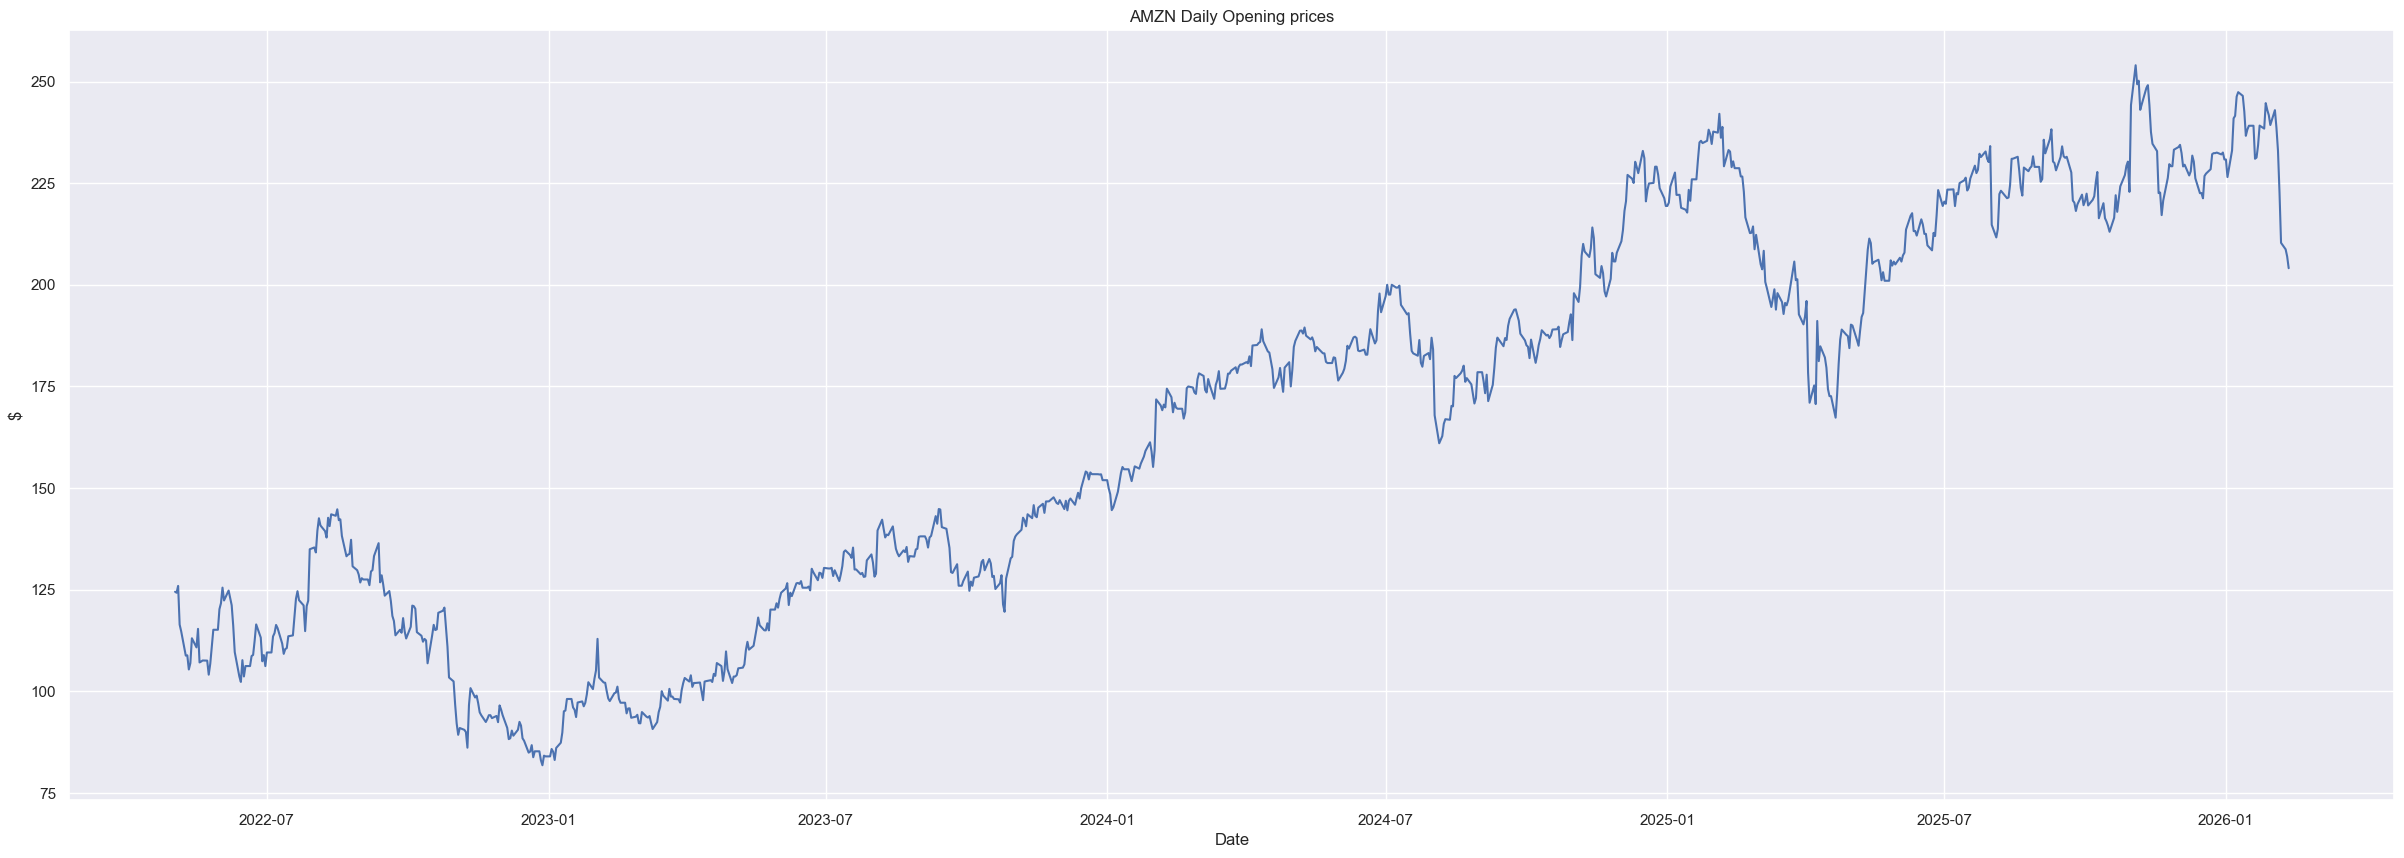

In [1072]:
plt.figure(figsize=(30,10))
sns.set_theme(style="darkgrid")
sns.lineplot(data=amzn, x="Date", y="Close")
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('$')
plt.title('AMZN Daily Opening prices')
plt.show()

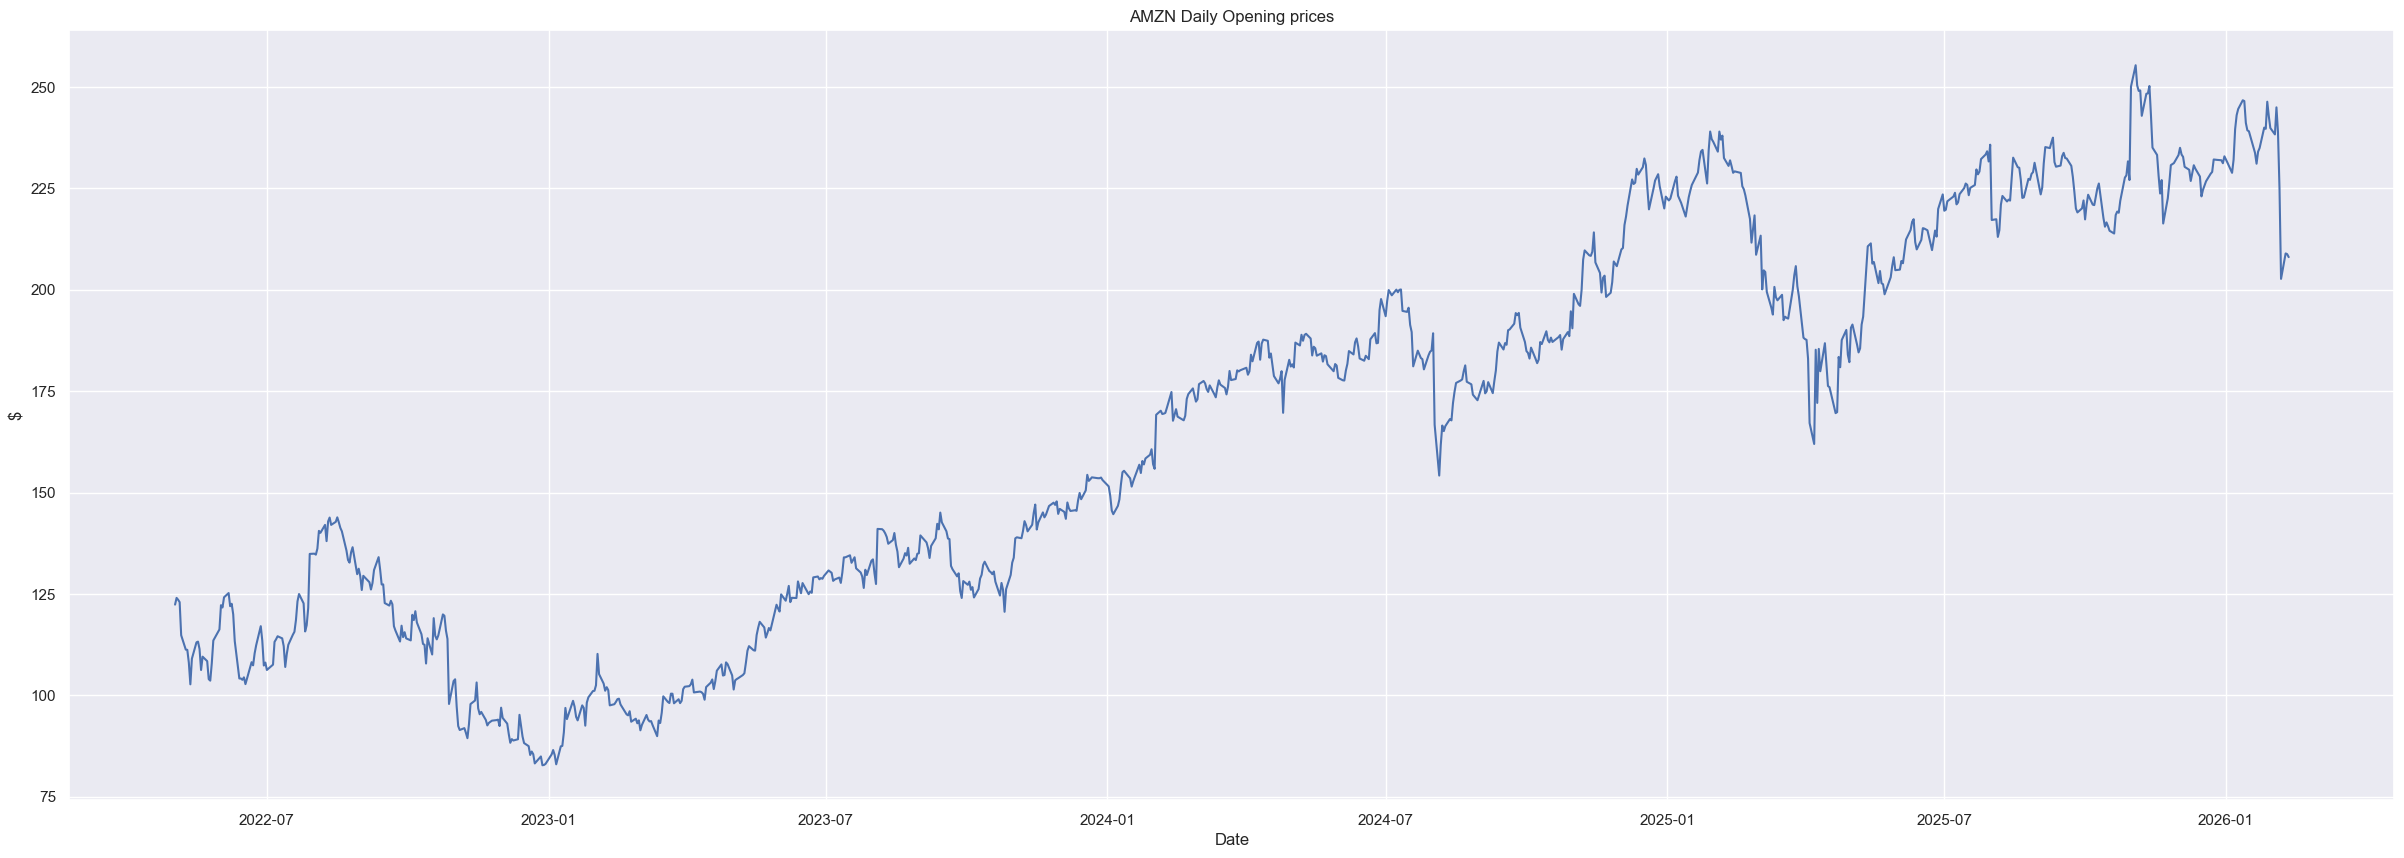

In [1073]:
plt.figure(figsize=(30,10))
sns.set_theme(style="darkgrid")
sns.lineplot(data=amzn, x="Date", y="Open")
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('$')
plt.title('AMZN Daily Opening prices')
plt.show()

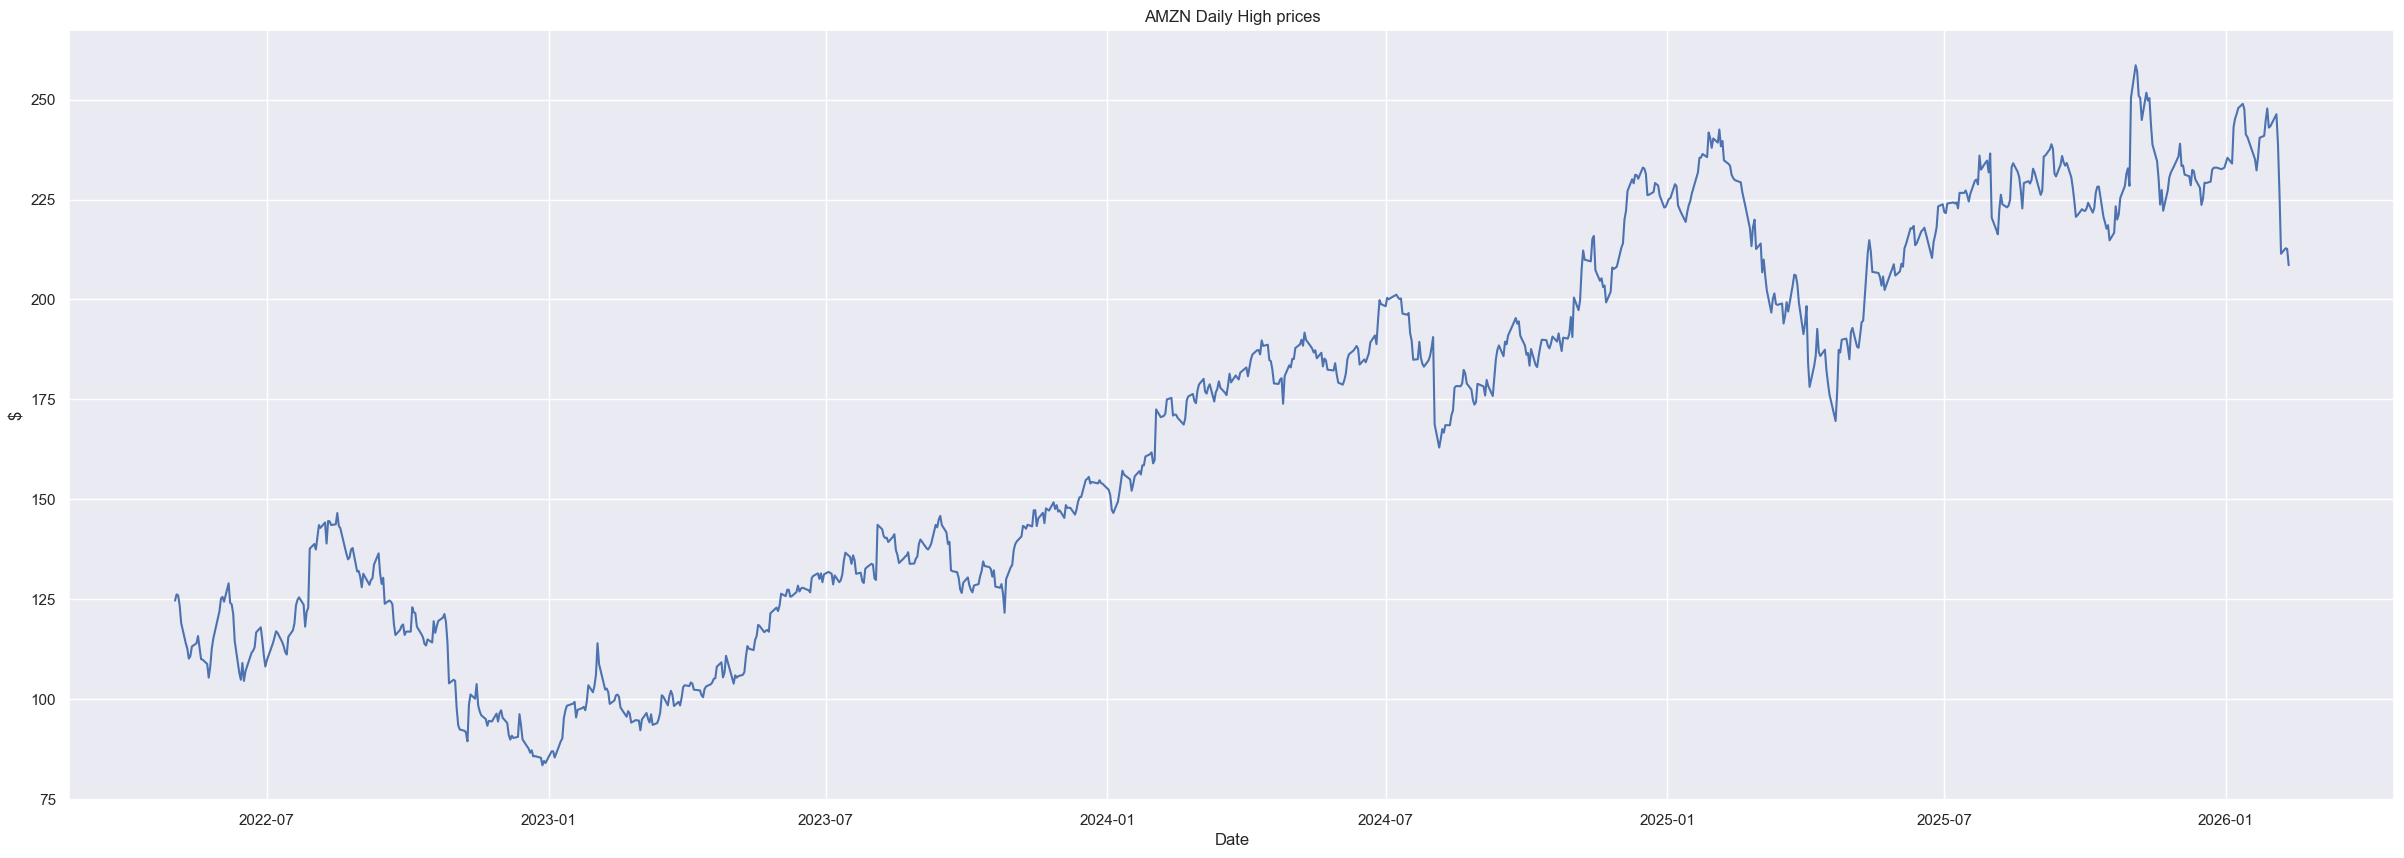

In [1074]:
plt.figure(figsize=(30,10))
sns.set_theme(style="darkgrid")
sns.lineplot(data=amzn, x="Date", y="High")
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('$')
plt.title('AMZN Daily High prices')
plt.show()

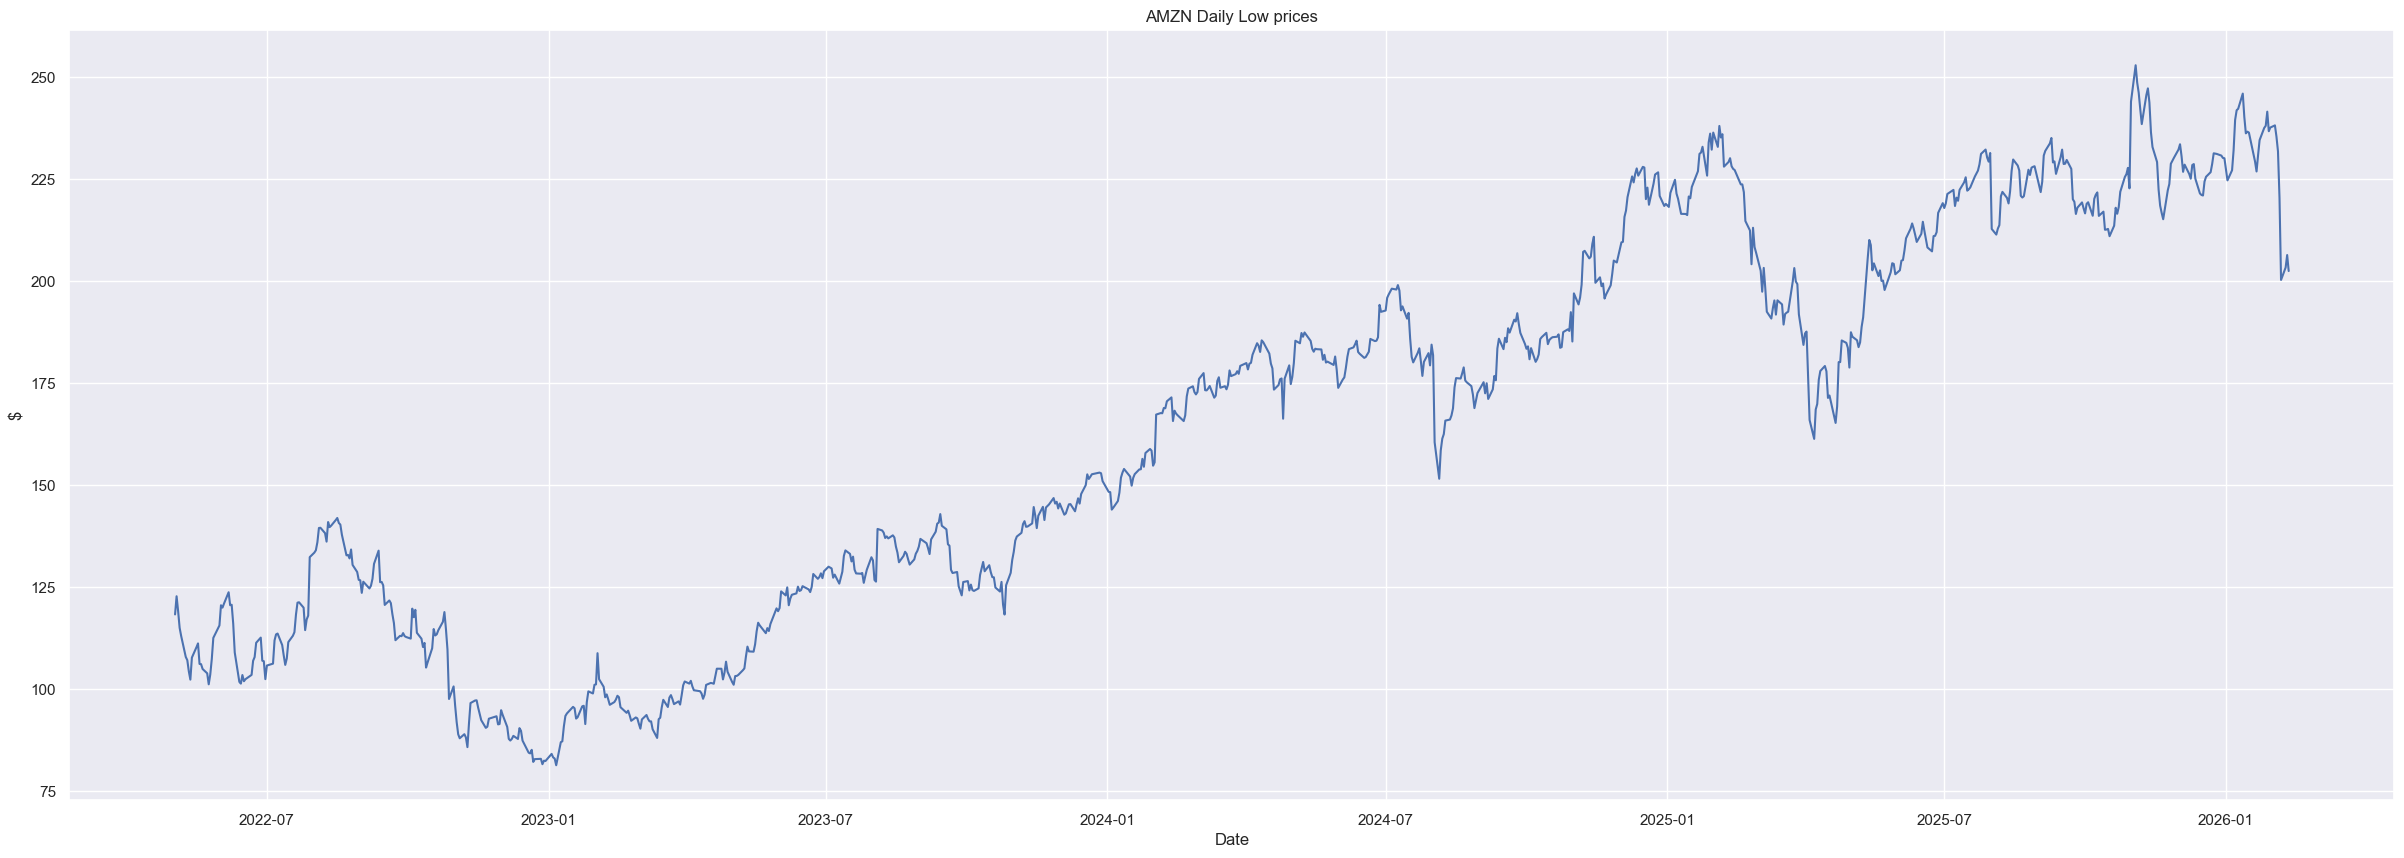

In [1075]:
plt.figure(figsize=(30,10))
sns.set_theme(style="darkgrid")
sns.lineplot(data=amzn, x="Date", y="Low")
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('$')
plt.title('AMZN Daily Low prices')
plt.show()

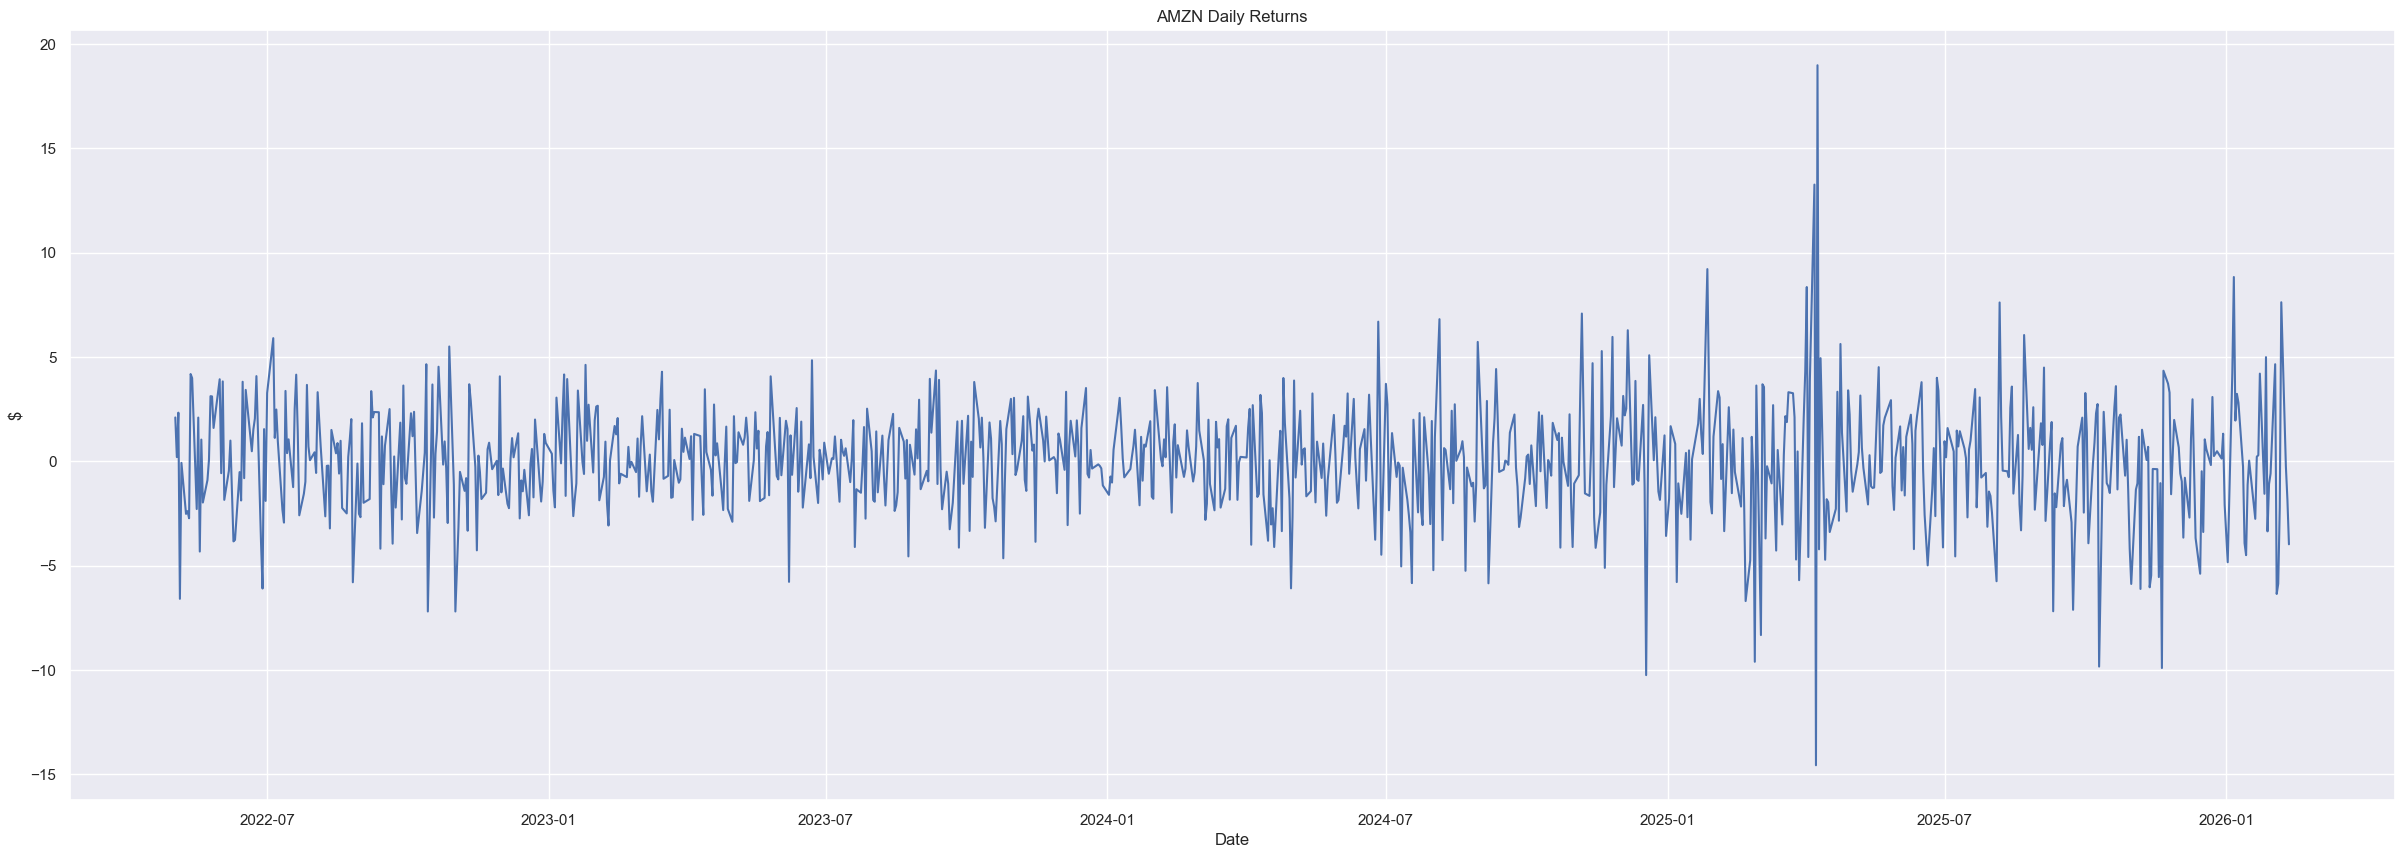

In [1076]:
#percent change from open-close
plt.figure(figsize=(30,10))
sns.set_theme(style="darkgrid")
sns.lineplot(data=amzn, x="Date", y="Return")
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('$')
plt.title('AMZN Daily Returns')
plt.show()




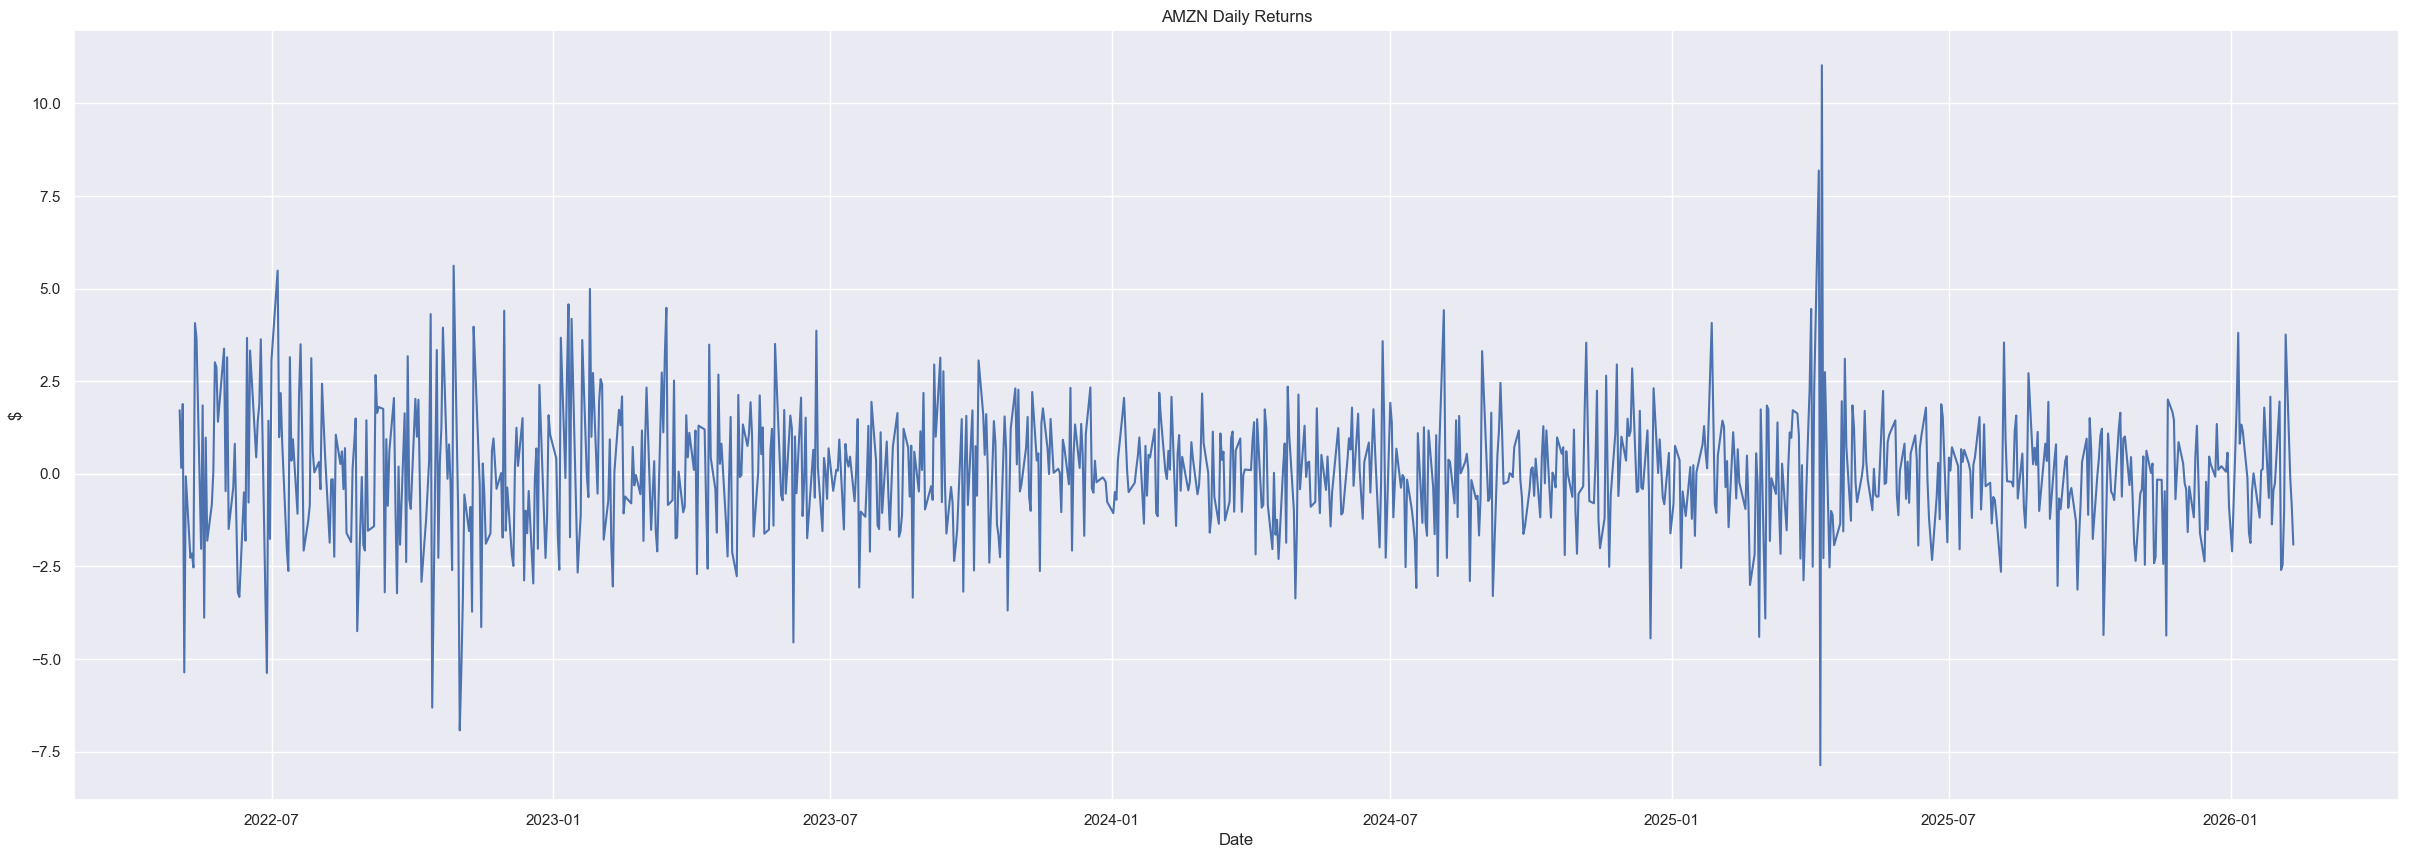

In [1077]:
#percent change from open-close
plt.figure(figsize=(30,10))
sns.set_theme(style="darkgrid")
sns.lineplot(data=amzn, x="Date", y="Pct Return")
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('$')
plt.title('AMZN Daily Returns')
plt.show()




##Seasonal Decomposition

<Figure size 640x480 with 0 Axes>

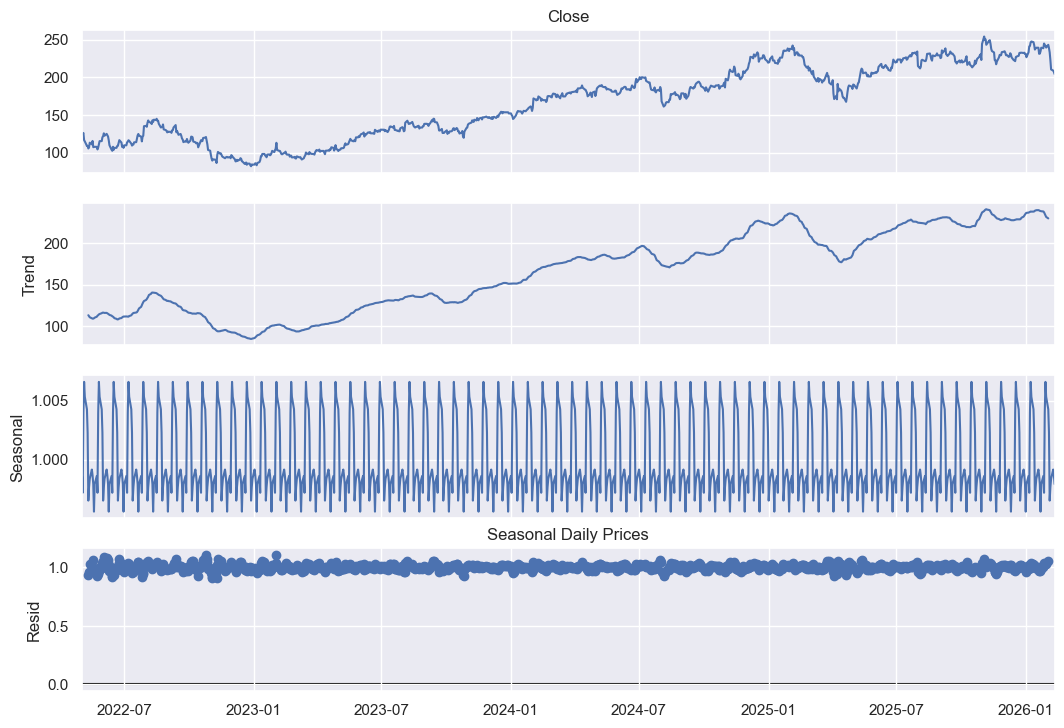

In [1078]:

result = seasonal_decompose(amzn['Close'], model='multiplicative', period=15)
fig = plt.figure()
fig = result.plot()
plt.title("Seasonal Daily Prices")
fig.set_size_inches(12, 8)
plt.show()


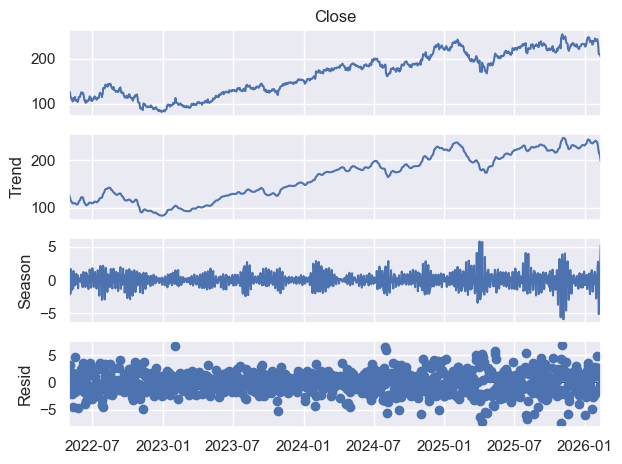

In [1079]:
from statsmodels.tsa.seasonal import STL

# STL handles the math a bit differently
stl = STL(amzn['Close'].ffill(), period=5)
res = stl.fit()
res.plot()
plt.show()

We observed trend and seasonality in our data.

#Checking close price data for normality and stationarity
* ADF test
* Normality Test

##ADF test
Augmented Dickey Fuller(ADF) test is a common statistical test used to test whether a given Time series is stationary or not.

In [1080]:
#diff versions of data
close=amzn['Close']
price_raw=close
returns = close.pct_change().dropna()
log_returns=np.log(close/close.shift(1)).dropna()


In [1081]:
def perform_adf_test(series, title):
    print(f'--- ADF Test for {title} ---')
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] <= 0.05:
        print("Result: Stationary (Reject Null Hypothesis) ✅")
    else:
        print("Result: Non-Stationary (Fail to Reject Null) ❌")
    print('\n')

In [1082]:
#run tests
perform_adf_test(price_raw, "Raw Close Price")
perform_adf_test(returns, "Daily Returns")
perform_adf_test(log_returns, "Log Returns")

--- ADF Test for Raw Close Price ---
ADF Statistic: -1.1647
p-value: 0.6886
Result: Non-Stationary (Fail to Reject Null) ❌


--- ADF Test for Daily Returns ---
ADF Statistic: -31.3920
p-value: 0.0000
Result: Stationary (Reject Null Hypothesis) ✅


--- ADF Test for Log Returns ---
ADF Statistic: -31.3449
p-value: 0.0000
Result: Stationary (Reject Null Hypothesis) ✅




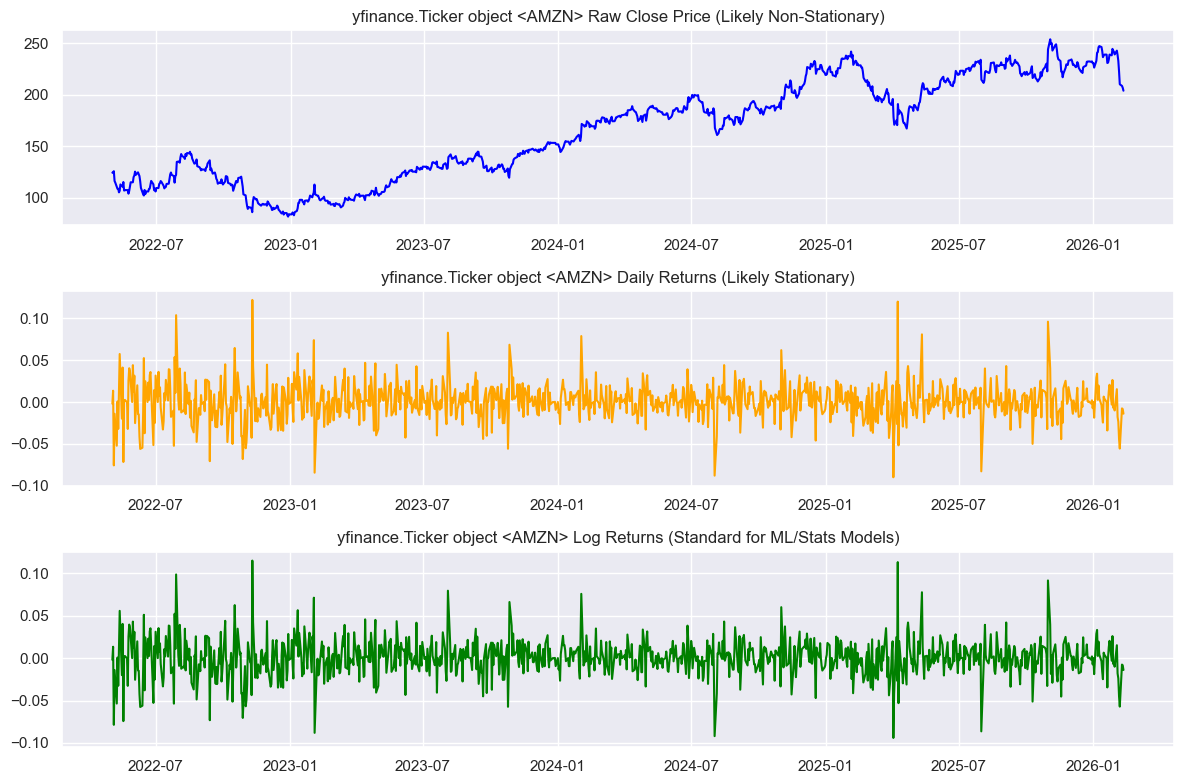

In [1083]:
# 4. Visualization
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(price_raw, color='blue')
plt.title(f'{ticker} Raw Close Price (Likely Non-Stationary)')

plt.subplot(3, 1, 2)
plt.plot(returns, color='orange')
plt.title(f'{ticker} Daily Returns (Likely Stationary)')

plt.subplot(3, 1, 3)
plt.plot(log_returns, color='green')
plt.title(f'{ticker} Log Returns (Standard for ML/Stats Models)')

plt.tight_layout()
plt.show()

##Normality Test

In [1084]:
result = adfuller(amzn['Close'])
stat, p = normaltest(amzn['Close'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
alpha = 0.05
if p > alpha:
    print('Data is normally distributed (fail to reject H0)')
else:
    print('Data is not normally distributed(reject H0)')
print('\n')


Statistics=4307.570, p=0.000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)




#log Transformation
The log transformation can be used to make highly skewed distributions less skewed.

In [1085]:
df_log = np.log(amzn['Close'] / amzn['Close'].shift(1))

In [1086]:
df_log.head()

Date
2022-05-02 00:00:00-04:00         NaN
2022-05-03 00:00:00-04:00   -0.001982
2022-05-04 00:00:00-04:00    0.013390
2022-05-05 00:00:00-04:00   -0.078622
2022-05-06 00:00:00-04:00   -0.014141
Freq: B, Name: Close, dtype: float64

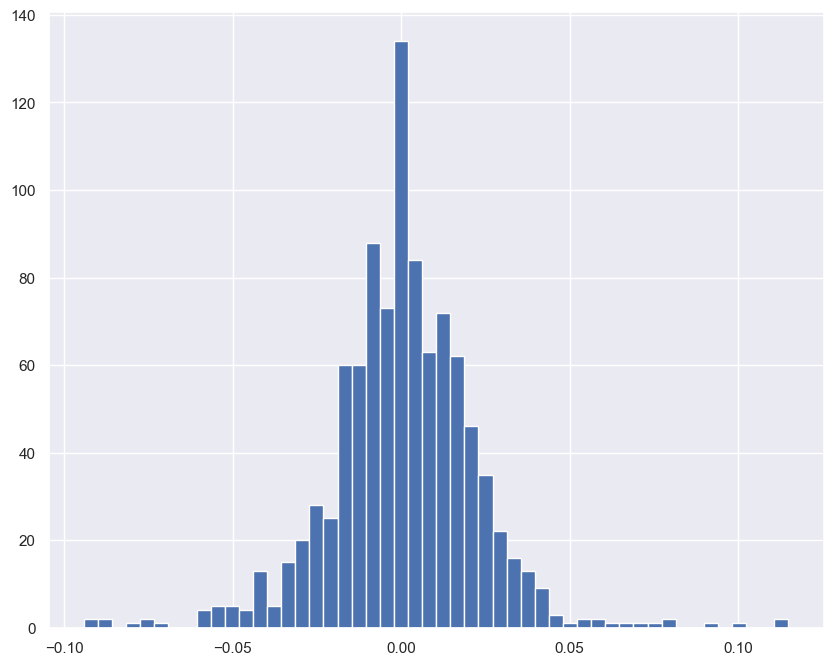

In [1087]:
df_log.hist(bins=50, figsize=(10, 8))
plt.show()

In [1088]:
df_log2 = df_log.dropna()

In [1089]:
df_log2.head()

Date
2022-05-03 00:00:00-04:00   -0.001982
2022-05-04 00:00:00-04:00    0.013390
2022-05-05 00:00:00-04:00   -0.078622
2022-05-06 00:00:00-04:00   -0.014141
2022-05-09 00:00:00-04:00   -0.053542
Freq: B, Name: Close, dtype: float64

#Using the log transformed data to do ADF and Normality test


##ADF test

In [1090]:

result = adfuller(df_log2, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
  print ("Reject Null Hypothesis. So, Time Series is Stationary")
else:
  print ("Failed to reject Null Hypothesis. So, Time Series is Non-Stationary")
print("\n")


ADF Statistic: -31.344947
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Reject Null Hypothesis. So, Time Series is Stationary




##Normality Test

In [1091]:
stat, p = normaltest(df_log2)
print('Test Statistics=%.3f, p=%.3f' % (stat, p))
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
alpha = 0.05
if p > alpha:
    print('Data is normally distributed (fail to reject H0)')
else:
    print('Data is not normally distributed(reject H0)')
print('\n')

Test Statistics=87.028, p=0.000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568
Data is not normally distributed(reject H0)




WeAMZN is not normally distributed... why?

###QQ plot
Quantile-Quantile Plot

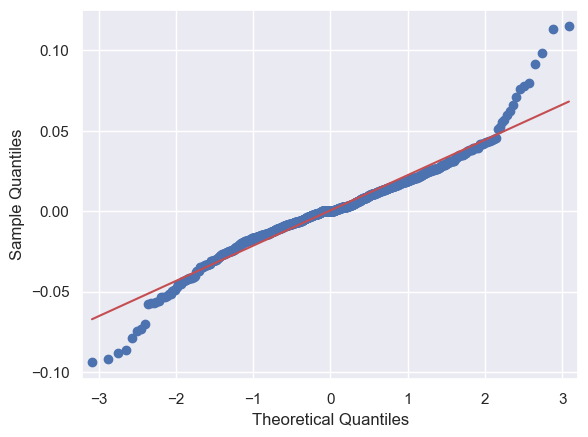

In [1092]:
fig = sm.qqplot(df_log2, line='s')
plt.show()

We can see that most of the points lie mostly along the straight diagonal line with some minor deviations along each of the tails.

Based on this plot, we could assume that set of data for AMZN is normally distributed.

#Constructing an ARIMA model with auto-fitting parameters (p,d,q)

In [1093]:
!pip install pmdarima

In [1094]:
from pmdarima import auto_arima

In [1095]:
def arima_auto(df):
    # 1. Setup Data
    split_point = int(len(df) * 0.8)
    train_data = list(df.iloc[:split_point])
    test_data = df.iloc[split_point:]
    actual_prices = amzn['Close'].iloc[split_point:].values

    predictions_log = []
    confidence_intervals_log = []

    # Use the last price from training to start the reconstruction
    current_base_price = amzn['Close'].iloc[split_point - 1]

    print("Running Rolling Forecast with Confidence Intervals...")
    for i in tqdm(range(len(test_data))):
        # 2. Fit model (p=1, q=1 forces the 'wiggle' you want)
        # We keep with_intercept=False to prevent the 250k drift
        model = auto_arima(train_data, start_p=1, start_q=1, d=0,
                           with_intercept=False, seasonal=False,
                           suppress_warnings=True)

        # 3. Predict 1-step ahead and get confidence interval
        pred, conf = model.predict(n_periods=1, return_conf_int=True)

        predictions_log.append(pred[0])
        confidence_intervals_log.append(conf[0])

        # 4. Update training data with the ACTUAL log return for the next step
        train_data.append(test_data.iloc[i])

    # 5. Transform back to Price Space
    forecast_prices = []
    lower_bounds = []
    upper_bounds = []

    for i in range(len(predictions_log)):
        # Calculate daily prediction based on the PREVIOUS day's actual price
        # This is what makes the line follow the 'bits' of data
        pred_price = current_base_price * np.exp(predictions_log[i])
        low_price = current_base_price * np.exp(confidence_intervals_log[i][0])
        high_price = current_base_price * np.exp(confidence_intervals_log[i][1])

        forecast_prices.append(pred_price)
        lower_bounds.append(low_price)
        upper_bounds.append(high_price)

        # Reset the base to the actual price for the next day's prediction
        current_base_price = actual_prices[i]

    # 6. Plotting
    plt.figure(figsize=(14, 7))
    plt.plot(amzn.index[split_point:], actual_prices, label='Actual Price', color='#ff7f0e', linewidth=2)
    plt.plot(amzn.index[split_point:], forecast_prices, label='Rolling Prediction', color='#2ca02c', linestyle='--')

    plt.fill_between(amzn.index[split_point:], lower_bounds, upper_bounds,
                     color='gray', alpha=0.3, label='95% Confidence Interval')

    plt.title('Amazon Rolling Forecast: Daily "Bits" with Confidence Ribbon', fontsize=16)
    plt.ylabel('Price (USD)')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()


Running Rolling Forecast with Confidence Intervals...


100%|██████████| 198/198 [02:52<00:00,  1.15it/s]


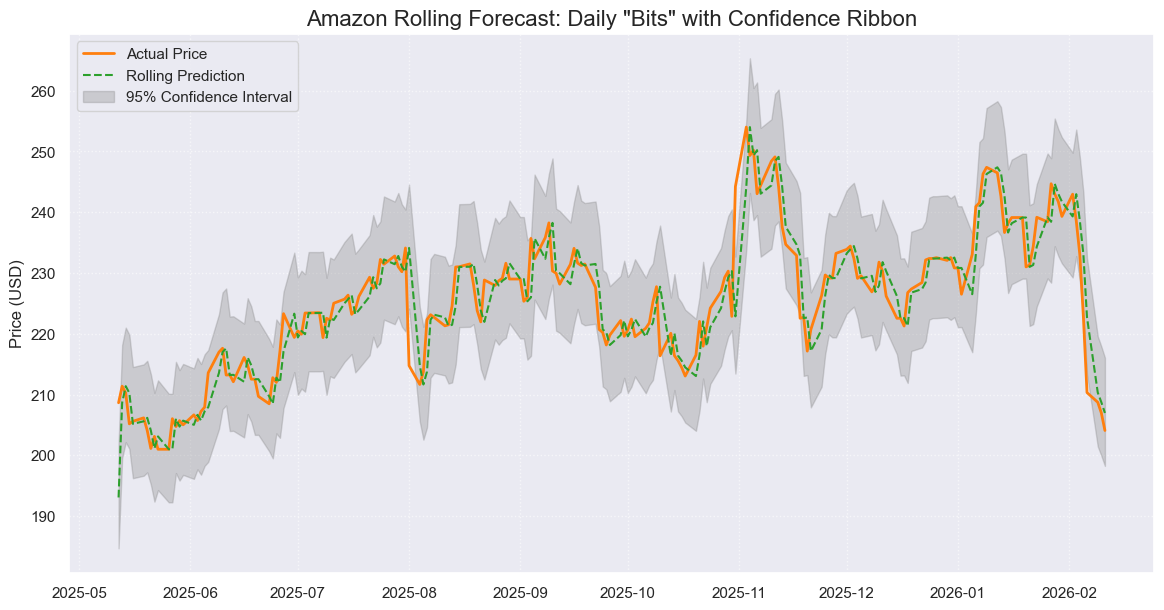

In [1099]:
df= np.log(amzn['Close']).diff().dropna()
amzn=amzn.loc[df.index]
arima_auto(df)


In [1113]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima

def forecast_table_next_week(df):
    print("Training initial model...")
    # 1. Train the model on history
    model = auto_arima(df, start_p=1, start_q=1, d=0,
                       with_intercept=True, # Allow for drift/trend
                       trend='c',
                       seasonal=False,
                       suppress_warnings=True)

    # 2. Setup for the "Fake Rolling" Loop
    n_days = 7
    future_predictions_log = []
    confidence_intervals = []

    # We need a list we can update.
    # (In a real rolling test, we added REAL data here. Now we add GUESSED data.)
    history = list(df)

    print(f"Recursively predicting {n_days} days into the future...")

    for i in range(n_days):
        # Predict ONE day ahead
        pred, conf = model.predict(n_periods=1, return_conf_int=True)

        # Save the guess
        future_predictions_log.append(pred[0])
        confidence_intervals.append(conf[0])

        # THE TRICK: Update the model with our own GUESS as if it were real
        # This changes the model's internal state for the next step
        model.update([pred[0]])

    # 3. Reconstruct Prices
    last_actual_price = amzn['Close'].iloc[-1]
    last_date = amzn.index[-1]

    # Generate Dates
    future_dates = pd.date_range(start=last_date, periods=n_days + 1, freq='B')[1:]

    # Convert Log-Returns to Price Levels
    # We use cumulative sum because each day adds to the previous
    price_path = last_actual_price * np.exp(np.cumsum(future_predictions_log))

    # Calculate Confidence Bounds (Square Root of Time Rule)
    daily_vol = np.std(df)
    steps = np.arange(1, n_days + 1)
    margin = 1.96 * daily_vol * np.sqrt(steps)

    lower_bounds = price_path * np.exp(-margin)
    upper_bounds = price_path * np.exp(margin)

    # 4. Create the "Pretty Table"
    forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Day': future_dates.day_name(),
        'Price': price_path,
        'Lower (95%)': lower_bounds,
        'Upper (95%)': upper_bounds,
        'Change': np.exp(future_predictions_log) - 1
    })

    # Styling
    styled = (forecast_df.style
              .format({
        'Price': '${:,.2f}',
        'Lower (95%)': '${:,.2f}',
        'Upper (95%)': '${:,.2f}',
        'Change': '{:+.2%}'
    })
              .background_gradient(subset=['Price'], cmap='Greens')
              .bar(subset=['Change'], align='mid', color=['#d65f5f', '#5fba7d'])
              .set_caption("Amazon Recursive Forecast (Simulated Rolling)")
              .hide(axis="index")
              )

    display(styled)
    return forecast_df

In [1114]:
final_table = forecast_table_next_week(df)

Training initial model...
Recursively predicting 7 days into the future...


C:\Users\17gil\AppData\Local\Temp\ipykernel_14228\279351243.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_predictions_log.append(pred[0])
C:\Users\17gil\AppData\Local\Temp\ipykernel_14228\279351243.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model.update([pred[0]])


Date,Day,Price,Lower (95%),Upper (95%),Change
2026-02-12 00:00:00-05:00,Thursday,$204.18,$195.59,$213.15,+0.05%
2026-02-13 00:00:00-05:00,Friday,$204.28,$192.23,$217.09,+0.05%
2026-02-16 00:00:00-05:00,Monday,$204.39,$189.72,$220.19,+0.05%
2026-02-17 00:00:00-05:00,Tuesday,$204.49,$187.64,$222.85,+0.05%
2026-02-18 00:00:00-05:00,Wednesday,$204.59,$185.84,$225.23,+0.05%
2026-02-19 00:00:00-05:00,Thursday,$204.69,$184.23,$227.42,+0.05%
2026-02-20 00:00:00-05:00,Friday,$204.79,$182.77,$229.46,+0.05%
